<a href="https://colab.research.google.com/github/tiq015UCSD/Making_Predictions_over_Amazon_Recommendation_Dataset/blob/main/Tian_Qin_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making Predictions over Amazon Recommendation Dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms. In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv('/content/drive/My Drive/Project/prj2/Reviews.csv')

In [24]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [25]:
# Data shape
df.shape 

(568454, 10)

In [26]:
# Check num of unique items per column
df.nunique() 

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [27]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [28]:
# Rename columns HelpfulnessNumerator and HelpfulnessDenominator
df.columns = ["Id", "ProductId", "UserId", "ProfileName", "VotesHelpful",
              "VotesTotal", "Score", "Time", "Summary", "Text"]

In [29]:
# Add the Sentiment column that turns the numeric score into either positive or negative.
df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")

In [30]:
df.head()

,Id,ProductId,UserId,ProfileName,VotesHelpful,VotesTotal,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


In [31]:
# check some statistics
df_sent_count = pd.DataFrame(df['Sentiment'].value_counts().to_frame('count').reset_index())
df_sent_count

,index,count
0,positive,443777
1,negative,124677


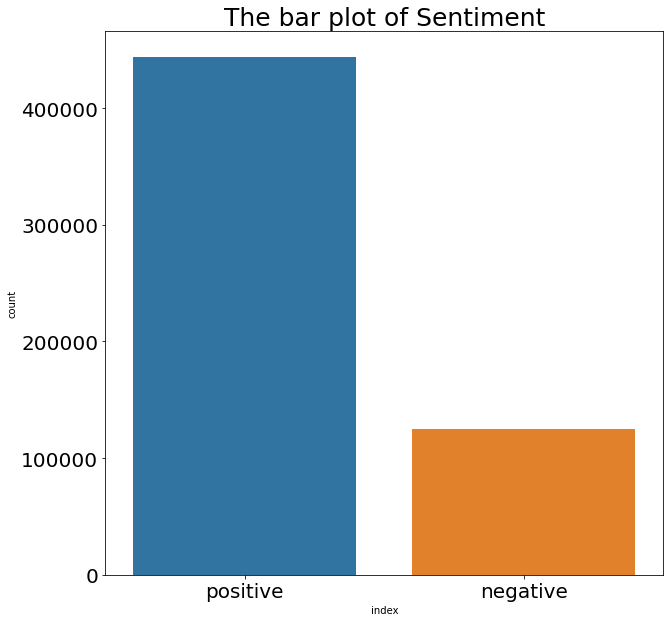

In [32]:
# The bar plot of sentiment
plt.figure(figsize=(10,10))
sns.barplot(data=df_sent_count, x='index', y='count')
plt.title('The bar plot of Sentiment', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [33]:
# Select required columns
df = df[["Score", "Sentiment", "Summary", "Text"]]

In [34]:
df.head()

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,positive,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,negative,Cough Medicine,If you are looking for the secret ingredient i...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning

## Change Words to Lower Case

In [35]:
# Change all words to lower case
df['Summary'] = df['Summary'].str.lower()

In [36]:
df.head()

,Score,Sentiment,Summary,Text
0,5,positive,good quality dog food,I have bought several of the Vitality canned d...
1,1,negative,not as advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,positive,"""delight"" says it all",This is a confection that has been around a fe...
3,2,negative,cough medicine,If you are looking for the secret ingredient i...
4,5,positive,great taffy,Great taffy at a great price. There was a wid...


## Remove Punctuation

In [37]:
# Punctuation removal
df['Summary'] = df['Summary'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [38]:
df.head()

,Score,Sentiment,Summary,Text
0,5,positive,good quality dog food,I have bought several of the Vitality canned d...
1,1,negative,not as advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,positive,delight says it all,This is a confection that has been around a fe...
3,2,negative,cough medicine,If you are looking for the secret ingredient i...
4,5,positive,great taffy,Great taffy at a great price. There was a wid...


## Stopwords

In [39]:
import nltk
from nltk.corpus import stopwords
# Stopwords list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'my', 'herself', 'didn', "weren't", 'you', 'itself', 'about', 'out', 'had', 'he', "shan't", 'which', 'those', 'most', 'our', 'does', 'once', 'nor', 'while', 'from', 'aren', "hasn't", 'such', 'll', 'ours', 'myself', 'your', 'below', 'if', 'how', 'theirs', 'again', 'd', 'here', 'there', 'y', 'am', 'after', 'off', 'they', 'more', 'of', 'have', 'few', 'mustn', 'who', 'that', 'for', 'just', "she's", 'before', 'is', 'both', 'where', 'ourselves', 'an', 'own', 'she', 'some', 'over', 'very', 'then', "aren't", 'i', 'above', "you're", 'their', 'or', "you'd", 'through', 'no', 'these', 'isn', 'being', 'during', 'doing', 'up', 'whom', 'hadn', 'with', 'o', "you'll", 'and', 'not', 'we', 'her', 'what', 'having', "you've", 'all', 'hers', "isn't", 'than', "don't", 'can', 'won', "it's", 'why', "doesn't", 'between', "shouldn't", 'are', 's', 'on', 't', 'doesn', 'him', 'by', 'his', "didn't", 'until', 'down', "should've", "needn't", 'me', 'any', 'were', 'has', 'm', 'against', 'couldn', 'each', 'mightn', 'now

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Since some words in stopwords will affect result such as don't, shouldn't etc. So we do not remove stopwords.

## Stemming

In [40]:
# Stemming
from nltk.stem import PorterStemmer
df['Summary_Stemming'] = df['Summary'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in str(x).split()]))
# Change sentiment to binary
df['Sentiment_Binary'] = df['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [41]:
df.head()

,Score,Sentiment,Summary,Text,Summary_Stemming,Sentiment_Binary
0,5,positive,good quality dog food,I have bought several of the Vitality canned d...,good qualiti dog food,1
1,1,negative,not as advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertis,0
2,4,positive,delight says it all,This is a confection that has been around a fe...,delight say it all,1
3,2,negative,cough medicine,If you are looking for the secret ingredient i...,cough medicin,0
4,5,positive,great taffy,Great taffy at a great price. There was a wid...,great taffi,1


## Word Cloud

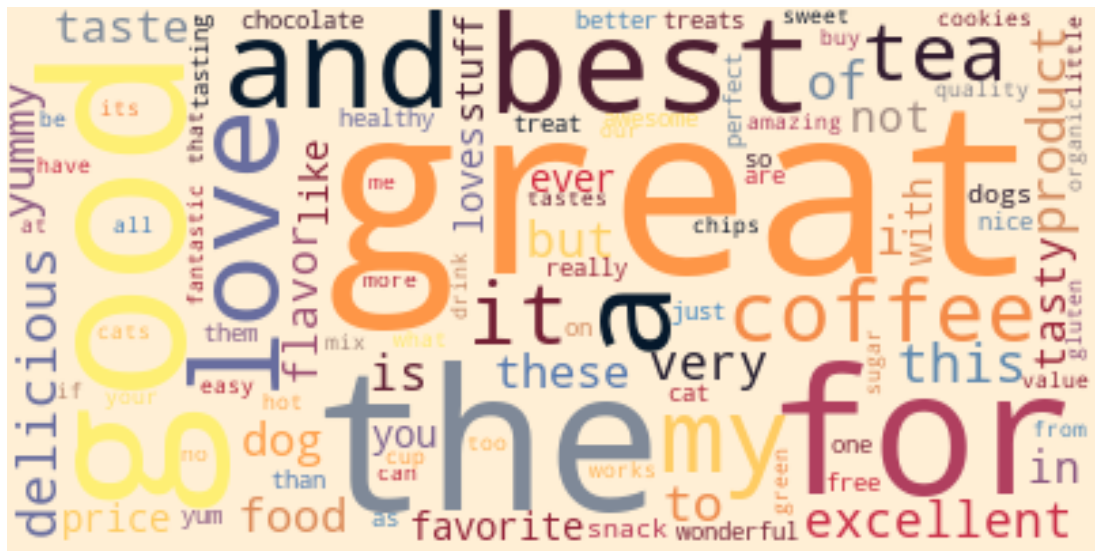

In [42]:
import texthero as hero
# Word Cloud of positive summary
hero.visualization.wordcloud(df[df['Sentiment_Binary']==1]["Summary"], max_words=100)

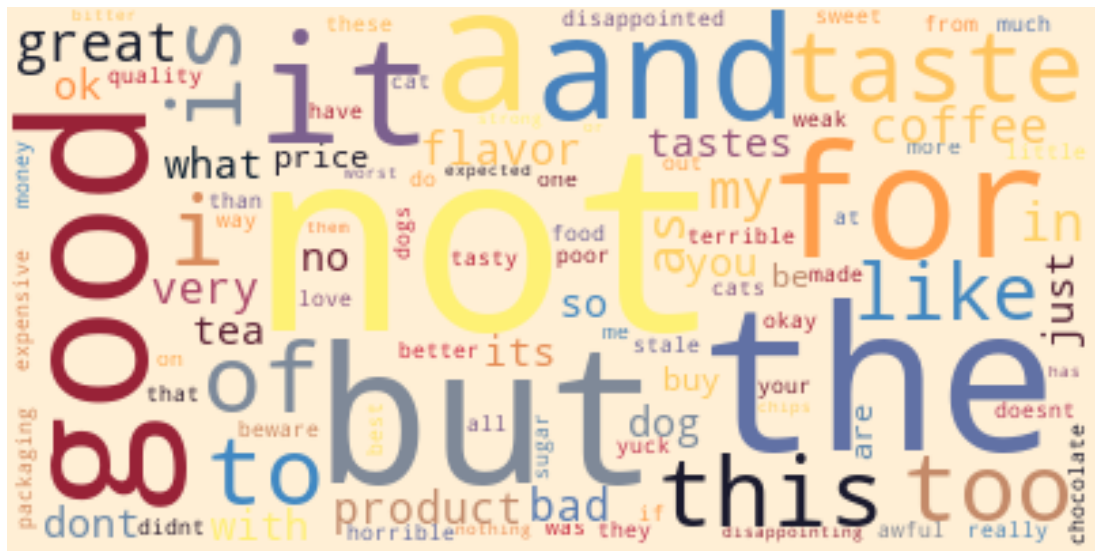

In [43]:
# Word Cloud of negative summary
hero.visualization.wordcloud(df[df['Sentiment_Binary']==0]["Summary"], max_words=100)

# Feature Engineering

## Split Dataset

In [44]:
# Split the data to train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=0)
train.shape, test.shape

((397917, 6), (170537, 6))

## TF-IDF 

In [45]:
# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5) # only use the word which shows up more than 5 times. 
tfidf_train = tfidf.fit_transform(train['Summary_Stemming'].values)
tfidf_test = tfidf.transform(test['Summary_Stemming'].values)
tfidf_train.shape, tfidf_test.shape

((397917, 42114), (170537, 42114))

 # Model Building

## Logistic Regression for TF-IDF

In [78]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression for TF-IDF
lg_tfidf = LogisticRegression()
lg_tfidf_result = lg_tfidf.fit(tfidf_train, train['Sentiment'])
lg_tfidf_predict = lg_tfidf.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [79]:
# Accuracy
lg_acc = lg_tfidf.score(tfidf_test, test['Sentiment'])
print('Accuracy of logistic regression is: %f' % lg_acc)

Accuracy of logistic regression is: 0.912570


In [81]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
lg_tfidf_cm = pd.DataFrame(confusion_matrix(test['Sentiment'], lg_tfidf_predict))
lg_tfidf_cm['Total'] = np.sum(lg_tfidf_cm, axis=1)
lg_tfidf_cm = lg_tfidf_cm.append(np.sum(lg_tfidf_cm, axis=0), ignore_index=True)
lg_tfidf_cm.columns = ['Predicted_Negative', 'Predicted_Positive', 'Total']
lg_tfidf_cm = lg_tfidf_cm.set_index([['Actual_Negative', 'Actual_Positive', 'Total']])
lg_tfidf_cm

,Predicted_Negative,Predicted_Positive,Total
Actual_Negative,26731,10707,37438
Actual_Positive,4203,128896,133099
Total,30934,139603,170537


In [83]:
# Stat Report
from sklearn.metrics import classification_report
lg_tfidf_report = classification_report(test['Sentiment'], lg_tfidf_predict)

In [84]:
print(lg_tfidf_report)

              precision    recall  f1-score   support

    negative       0.86      0.71      0.78     37438
    positive       0.92      0.97      0.95    133099

    accuracy                           0.91    170537
   macro avg       0.89      0.84      0.86    170537
weighted avg       0.91      0.91      0.91    170537



## Random Forest for TF-IDF

In [51]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf_tfidf = RandomForestClassifier(n_estimators = 10, class_weight = 'balanced', n_jobs = -1)
rf_tfidf_result = rf_tfidf.fit(tfidf_train, train['Sentiment'])
rf_tfidf_predict = rf_tfidf.predict(tfidf_test)

In [57]:
# Accuracy
rf_acc = rf_tfidf.score(tfidf_test, test['Sentiment'])
print('Accuracy of random forest is: %f' % rf_acc)

Accuracy of random forest is: 0.913180


In [59]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
rf_tfidf_cm = pd.DataFrame(confusion_matrix(test['Sentiment'], rf_tfidf_predict))
rf_tfidf_cm['Total'] = np.sum(rf_tfidf_cm, axis=1)
rf_tfidf_cm = rf_tfidf_cm.append(np.sum(rf_tfidf_cm, axis=0), ignore_index=True)
rf_tfidf_cm.columns = ['Predicted_Negative', 'Predicted_Positive', 'Total']
rf_tfidf_cm = rf_tfidf_cm.set_index([['Actual_Negative', 'Actual_Positive', 'Total']])
rf_tfidf_cm

,Predicted_Negative,Predicted_Positive,Total
Actual_Negative,30861,6577,37438
Actual_Positive,8229,124870,133099
Total,39090,131447,170537


In [60]:
# Stat Report
from sklearn.metrics import classification_report
rf_tfidf_report = classification_report(test['Sentiment'], rf_tfidf_predict)

In [61]:
print(rf_tfidf_report)

              precision    recall  f1-score   support

    negative       0.79      0.82      0.81     37438
    positive       0.95      0.94      0.94    133099

    accuracy                           0.91    170537
   macro avg       0.87      0.88      0.88    170537
weighted avg       0.91      0.91      0.91    170537



# Model evaluation

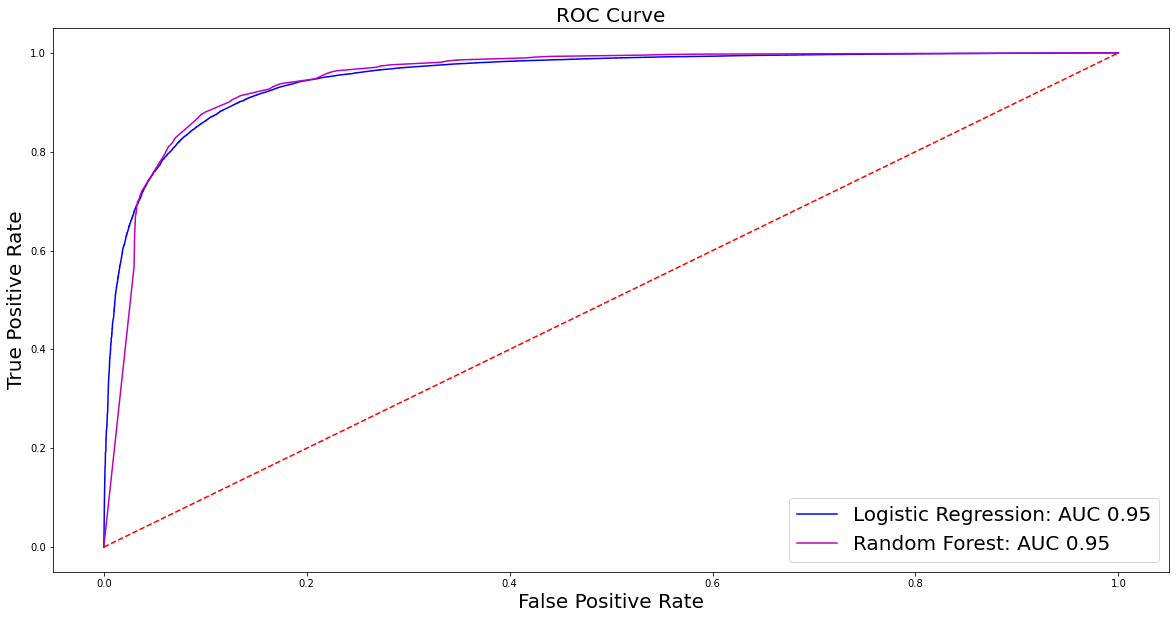

In [86]:
# ROC curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
# Roc of Logistic Regerssion
lg_tfidf_prob = lg_tfidf.predict_proba(tfidf_test)
lg_fpr, lg_tpr, lg_thresholds = roc_curve(test['Sentiment'], lg_tfidf_prob[:,1], pos_label='positive')
lg_roc_auc = auc(lg_fpr, lg_tpr)
# Roc of Random Forest
rf_tfidf_prob = rf_tfidf.predict_proba(tfidf_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(test['Sentiment'], rf_tfidf_prob[:,1], pos_label='positive')
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(20,10))
plt.plot(lg_fpr, lg_tpr, color='b', label='%s: AUC %0.2f'% ('Logistic Regression', lg_roc_auc))
plt.plot(rf_fpr, rf_tpr, color='m', label='%s: AUC %0.2f'% ('Random Forest', rf_roc_auc))
plt.title('ROC Curve', fontsize=20)
plt.legend(loc='lower right', fontsize=20)
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.show()

# Feature Importance

## By Logistic Regerssion

In [90]:
# Coefficient of each word
feature = tfidf.get_feature_names()
coef_lg = lg_tfidf.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : feature, 'Coefficient' : coef_lg})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [88]:
# Top 10 Words with highest coefficient
coeff_df.head(10)

,Word,Coefficient
4007,best,12.300463
16053,great,10.826450
25156,not bad,10.292505
11785,excel,10.126564
9608,delici,8.578636
25477,not too,8.083270
2995,awesom,7.645460
28013,perfect,7.610897
21944,love,7.507786
40973,wonder,7.031592


In [89]:
# Top 10 Words with lowest coefficient
coeff_df.tail(10)

,Word,Coefficient
3187,bad,-6.839082
10014,didnt,-6.913677
39912,weak,-6.928226
28565,poor,-6.956425
33266,stale,-7.368330
2955,aw,-7.562774
18084,horribl,-8.517530
35279,terribl,-8.655192
41195,worst,-10.319386
25126,not,-10.704098


## By Random Forest

In [91]:
# Importance of each word
importance_rf = rf_tfidf.feature_importances_
importance_df = pd.DataFrame({'Word' : feature, 'Importance' : importance_rf})
importance_df = importance_df.sort_values(['Importance', 'Word'], ascending=[0, 1])

In [92]:
# Top 10 Words with highest importance
importance_df.head(10)

,Word,Importance
25126,not,0.038220
16053,great,0.030881
4007,best,0.015961
9608,delici,0.015259
10209,disappoint,0.011131
5580,but,0.010221
15379,good,0.009823
21944,love,0.009291
11785,excel,0.008359
41905,yummi,0.008040


In [93]:
# Top 10 Words with lowest importance
importance_df.tail(10)

,Word,Importance
41928,yummi combin,0.0
41960,yummi hard,0.0
41982,yummi nutriti,0.0
42042,yummymi treat,0.0
42057,zero is,0.0
42068,zevia flavor,0.0
42080,zing of,0.0
42092,ziwipeak great,0.0
42096,zoe favorit,0.0
42108,zuke hipact,0.0
